In [1]:
import GWPhotonCounting
import jax.numpy as jnp
import jax
import numpy as np
import bilby
from bilby_cython.geometry import frequency_dependent_detector_tensor

import json

from astropy.cosmology import Planck18
import astropy.units as u
from tqdm import tqdm


frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))

# Setting up the two detectors to compare the 
detector_CE1 = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE1_shot_psd_updated.csv', 
    '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE1_classical_quanta_updated.csv', 
    gamma=100, random_seed=1632, N_frequency_spaces=10)

detector_CE2silica = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE2silica_sqz_total_psd.csv', None,
    gamma=100, random_seed=1632, N_frequency_spaces=10)

detector_CE2silicon = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE2silicon_shot_psd.csv', 
    '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE2silicon_classical_quanta.csv',
    gamma=100, random_seed=1632, N_frequency_spaces=10)

detector_CE2silicon_sqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE2silicon_sqz_total_psd.csv', None,
    gamma=100, random_seed=1632, N_frequency_spaces=10)

#Loading in the individual analysis from the sample
KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/home/ethan.payne/code_libraries/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()
dataset = np.genfromtxt(f'/home/ethan.payne/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_updated.dat')

/home/ethan.payne/code_libraries/bilby/bilby/gw/detector/geometry.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import ROT_DAY, DAYJUL_SI
/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ethan.payne/.conda/envs/ve310/lib/python3.10/sit

In [2]:
mtots, z, phi, psi, ra, dec, iota, fpeak_true, snr, snr_silica, snr_silicon = dataset.T

In [44]:
# Set Nevents 
Nevents = 1

# Generate the strain array 
PM_strain_array = []

for i in tqdm(range(Nevents)):
    PM_strain = KNNModel.generate_strain(detector_CE1, frequencies, mtots[i], phi[i], z[i], ra[i], dec[i], iota[i], psi[i])

    PM_strain_array.append(PM_strain)

PM_strain_array = np.array(PM_strain_array)

100%|██████████| 1/1 [00:00<00:00, 54.81it/s]


In [45]:
# Setting up the likelihood
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()
noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood() 
gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()
# Use GWPhotonCounting.distributions.GeometricPhotonLikelihood() if you want a geometric distribution

# Setting up the convolution of the noise and poisson distributions
convolved_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)

In [62]:
# Calculation for the CE1 detector
noise_photons_sum_array = []
signal_photons_sum_array = []
signal_photons_no_background_array = []

observed_photons_array = []
observed_photons_no_background_array = []
observed_strain_array = []

for i in tqdm(range(Nevents)):
    observed_photons, signal_photons, noise_photons = convolved_likelihood.generate_realization(
        detector_CE1.calculate_signal_photon_expectation(PM_strain_array[i], frequencies), 
        detector_CE1.noise_photon_expectation)
    observed_photons_no_background = poisson_likelihood.generate_realization(
        detector_CE1.calculate_signal_photon_expectation(PM_strain_array[i], frequencies))
    observed_strain = PM_strain_array[i] + gaussian_likelihood.generate_realization(detector_CE2silica.total_psd, frequencies)

    noise_photons_sum_array.append(jnp.sum(noise_photons))
    signal_photons_sum_array.append(jnp.sum(signal_photons))
    signal_photons_no_background_array.append(jnp.sum(observed_photons_no_background))

    observed_photons_array.append(observed_photons)
    observed_photons_no_background_array.append(observed_photons_no_background)
    observed_strain_array.append(observed_strain)

observed_photons_array = np.array(observed_photons_array)
observed_photons_no_background_array = np.array(observed_photons_no_background_array)
observed_strain_array = np.array(observed_strain_array)

noise_photons_sum_array = np.array(noise_photons_sum_array)
signal_photons_sum_array = np.array(signal_photons_sum_array)
signal_photons_no_background_array = np.array(signal_photons_no_background_array)

100%|██████████| 1/1 [00:00<00:00, 61.55it/s]


In [63]:
print(f'Noise Photons Sum: {jnp.sum(noise_photons_sum_array)}')
print(f'Signal Photons Sum: {jnp.sum(signal_photons_sum_array)}')
print(f'Signal Photons No Background Sum: {jnp.sum(signal_photons_no_background_array)}')

Noise Photons Sum: 1.0
Signal Photons Sum: 0
Signal Photons No Background Sum: 0


In [64]:
# Generat the frequencies from radius
R1d6s = np.linspace(9,15,25)

f0_R1d6s = []

for i in range(Nevents):
    f0 = GWPhotonCounting.hierarchical.frequency_model(mtots[i], R1d6s)/(1+z[i])

    f0_R1d6s.append(f0)

f0_R1d6s = np.array(f0_R1d6s)

In [65]:
amplitude_array = []

for i in tqdm(range(Nevents)):
    amplitude = 7.28e-4 * (1+z[i])/Planck18.luminosity_distance(z[i]).value / 3.085677581491367e+22 * mtots[i] * 2e30 * 6.67e-11/(3e8)**2

    detector_CE1.ifo.fd_detector_tensor = frequency_dependent_detector_tensor(
        np.array(frequencies),
        ra[i],
        dec[i],
        0,
        detector_CE1.ifo.x,
        detector_CE1.ifo.y,
        detector_CE1.ifo.free_spectral_range,
    )

    fp = detector_CE1.ifo.antenna_response(ra[i], dec[i], 0, psi[i], 'plus', frequency=f0_R1d6s)
    fc = detector_CE1.ifo.antenna_response(ra[i], dec[i], 0, psi[i], 'cross', frequency=f0_R1d6s)

    amplitude *= ((1+jnp.cos(iota[i])**2)/2 * fp + jnp.cos(iota[i]) * fc) * (2 * jnp.sqrt(2) * jnp.pi**(3/2))

    amplitude_array.append(amplitude)

amplitude_array = np.array(amplitude_array)

100%|██████████| 1/1 [00:00<00:00, 247.23it/s]


In [ ]:
# Set up the individual event log likelihoods

N_gamma = 10
N_phase = 100
N_t0s = 10

individual_loglikelihoods = []
individual_loglikelihoods_no_background = []
individual_loglikelihoods_strain = []

for i in tqdm(range(Nevents)):

    likelihood_event_i = np.zeros(len(f0_R1d6s[i]))
    likelihood_event_i_no_background = np.zeros(len(f0_R1d6s[i]))
    likelihood_event_i_strain = np.zeros(len(f0_R1d6s[i]))

    for l, f0 in enumerate(f0_R1d6s[i]):

        A = amplitude_array[i][l]

        likelihood_array_i = np.zeros((N_gamma,N_phase))
        likelihood_array_i_no_background = np.zeros((N_gamma,N_phase))
        likelihood_array_i_strain = np.zeros((N_gamma,N_phase))

        t0s = jnp.linspace(-0.02, 0.02, N_t0s)

        print(l,f0)

        for j, gamma in enumerate(np.linspace(1e-6, 400, N_gamma)):
            for k, phi0 in enumerate(np.linspace(0, 2*np.pi, N_phase)):

                expected_photon_count_signal = LorentzianModel.generate_photon_count(
                    detector_CE1, frequencies, f0=f0, gamma=gamma, A=A*gamma, phase=phi0, t0=t0s)
                expected_strain = LorentzianModel.generate_strain(
                    detector_CE1, frequencies, f0=f0, gamma=gamma, A=A*gamma, phase=phi0, t0=t0s)
                
                
                likelihood_array_i[j,k] = convolved_likelihood(
                    observed_photons_array[i], expected_photon_count_signal, detector_CE1.noise_photon_expectation)
                
                likelihood_array_i_no_background[j,k] = poisson_likelihood(
                    observed_photons_no_background_array[i], expected_photon_count_signal)
            
                likelihood_array_i_strain[j,k] = gaussian_likelihood(observed_strain_array[i], expected_strain, detector_CE1.total_psd, frequencies)

        likelihood_event_i[l] = jax.scipy.special.logsumexp(likelihood_array_i) - jnp.log(len(likelihood_array_i.flatten()))
        likelihood_event_i_no_background[l] = jax.scipy.special.logsumexp(likelihood_array_i_no_background) - jnp.log(len(likelihood_array_i_no_background.flatten()))
        likelihood_event_i_strain[l] = jax.scipy.special.logsumexp(likelihood_array_i_strain) - jnp.log(len(likelihood_array_i_strain.flatten()))

    individual_loglikelihoods.append(likelihood_event_i)
    individual_loglikelihoods_no_background.append(likelihood_event_i_no_background)
    individual_loglikelihoods_strain.append(likelihood_event_i_strain)

individual_loglikelihoods = np.array(individual_loglikelihoods)
individual_loglikelihoods_no_background = np.array(individual_loglikelihoods_no_background)
individual_loglikelihoods_strain = np.array(individual_loglikelihoods_strain)

  0%|          | 0/1 [00:00<?, ?it/s]

0 1544.7819230399775
1 1488.6739202476438
2 1434.298350162089
3 1381.6552127833138
4 1330.7445081113196
5 1281.566236146104
6 1234.1203968876684
7 1188.4069903360141
8 1144.4260164911384
9 1102.1774753530428
10 1061.6613669217274
11 1022.8776911971918
12 985.8264481794358
13 950.5076378684596
14 916.9212602642631
15 885.0673153668471
16 854.9458031762114
17 826.5567236923536
18 799.9000769152769
19 774.9758628449807
20 751.7840814814631
21 730.3247328247269
22 710.5978168747687
23 692.6033336315911
24 676.3412830951928


100%|██████████| 1/1 [13:29<00:00, 809.90s/it]


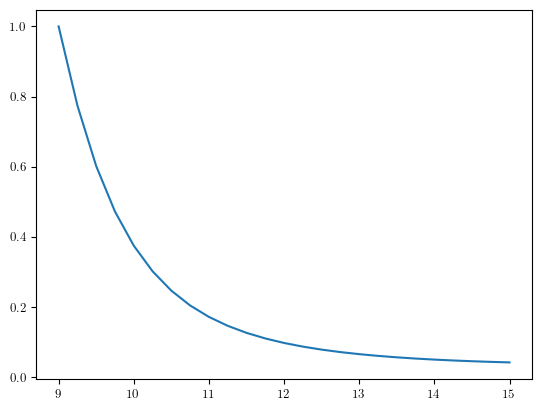

In [68]:
import matplotlib.pyplot as plt

plt.plot(R1d6s, jnp.exp(jnp.sum(individual_loglikelihoods_no_background,axis=0) - jnp.max(jnp.sum(individual_loglikelihoods_no_background,axis=0))))

In [70]:
data = {'logls':list(individual_loglikelihoods[0]), 'logls_no_background':list(individual_loglikelihoods_no_background[0]), 
        'logls_strain':list(individual_loglikelihoods_strain[0])}

json.dump(data, open('logls.json','w'))